In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

# https://github.com/tensorflow/tensorflow/issues/24828
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()

In [2]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize_image_with_crop_or_pad(image,224,224)
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.image.random_crop(image, (224, 224, 3)),
    # tf2.0 somehow returns the above as a tuple with length 1
    image = tf.image.random_flip_left_right(image[0])
#     image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2),
    # tf2.0 somehow returns the above as a tuple with length 1
    image = image[0]/255  # normalize to [0,1] range
    return image

W0416 19:05:39.931986 139808075265792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


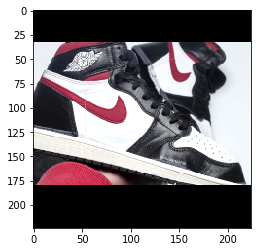

In [3]:
path = "/home/nan/sneaker_ai/screened_data/air_jordan_1/air_jordan_1_362.png"
plt.imshow(load_and_preprocess_image(path))

W0416 19:05:40.079253 139808075265792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/nan/sneaker_ai/screened_data/air_jordan_17/air_jordan_17_90.png


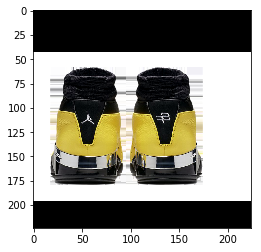

In [4]:
import random

train_df = pd.read_csv("train_df.csv")
indx = random.randint(0, len(train_df))
path = train_df.iloc[indx, 1]
print(path)
plt.imshow(load_and_preprocess_image(path))

In [5]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_image_paths = train_df.loc[:, "Image_File"].tolist()
train_image_labels = train_df.loc[:, "Label"].tolist()
label_names = ["AJ "+str(i) for i in range(1,24)]
label_to_index = dict((name, index) 
                      for index, name in enumerate(label_names))

In [6]:
path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
# print('shape: ', repr(train_ds.shapes))
# print('type: ', train_ds.types)
print()
print(path_ds)
image_ds = path_ds.map(load_and_preprocess_image)


<TensorSliceDataset shapes: (), types: tf.string>


W0416 19:05:40.412304 139808075265792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0416 19:05:40.428177 139808075265792 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


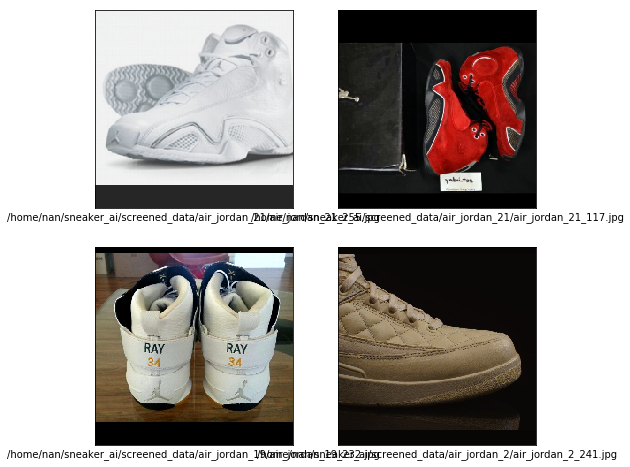

In [7]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_image_paths[n])

In [8]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [9]:
# Alternative and more compact method
ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [10]:
BATCH_SIZE = 16
image_count = len(train_df)
# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# ds = image_label_ds.shuffle(buffer_size=len(train_df))
# ds = ds.repeat()
# ds = ds.batch(BATCH_SIZE)
# # `prefetch` lets the dataset fetch batches, in the background while the model is training.
# ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# ds
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False)
mobile_net.trainable=False

In [12]:
# MobileNetV2: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
# imagenet.utils: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
# mobile net expects prepocessed input ranging from -1 to 1
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [13]:
image_batch, label_batch = next(iter(keras_ds))

In [14]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(16, 7, 7, 1280)


In [15]:
model = tf.keras.Sequential([
    mobile_net,
    # take an average of each channel so that the model woks with different input sizes
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax)])

In [16]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()
print(logit_batch.max(axis=1))

print("Shape:", logit_batch.shape)
# tf.keras.losses.sparse_categorical_crossentropy(tf.convert_to_tensor(logit_batch.max(axis=1)), model(image_batch))

min logit: 0.0017033059
max logit: 0.36581886

[0.09054653 0.19370449 0.14506896 0.32614413 0.12362379 0.16937818
 0.36581886 0.19986625 0.12262095 0.1087577  0.11336079 0.13676426
 0.08739631 0.1577697  0.1449722  0.10460223]
Shape: (16, 23)


In [17]:
# logit_batch
temp = image_batch.numpy()[8]
print(temp.min())
print(temp.max())

-0.957668
0.9337547


In [18]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [19]:
len(model.trainable_variables)
# weights and bias if mobilenet was not set to be trainable

4

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                5911      
Total params: 2,591,831
Trainable params: 333,847
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
num_epochs = 3


# model.fit(ds, epochs=num_epochs)
model.fit(keras_ds, epochs=num_epochs)
# for epoch in range(num_epochs):
#     model.fit(keras_ds)
#     model.evaluate()

Epoch 1/3
307/355 [========================>.....] - ETA: 10s - loss: 2.8590 - accuracy: 0.1769

KeyboardInterrupt: 

In [ ]:
x=tf.random.uniform([3,3])
print("Is there GPU available:")
print(tf.test.is_gpu_available())
print("Is the tensor on GPU #0: ")
print(x.device.endswith('GPU:0'))

import time
def time_matmul(x):
    start = time.time()
    for loop in range(100):
        tf.matmul(x,x)
    result = time.time() - start
    print("100 loops: {:0.2f}ms".format(1000*result))
    
print("On CPU")
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)
    
print("On GPU")
with tf.device("GPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)